In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Flatten, Add, Dropout, Conv2D, BatchNormalization, Activation, Concatenate
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, multiply, add
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from keras.initializers import he_normal

In [2]:
# data preparation
dataset_dir =  r'D:\Project\Deep Learning - Research\programs\MV-couswork\Brain Tumor Data Set\BrainTumorProcessed'
input_shape = (256, 256, 3)
batch_size = 4
num_classes = 2

In [3]:
# data augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_datagen = ImageDataGenerator(
rescale = 1./255
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 3103 images belonging to 2 classes.
Found 665 images belonging to 2 classes.
Found 666 images belonging to 2 classes.


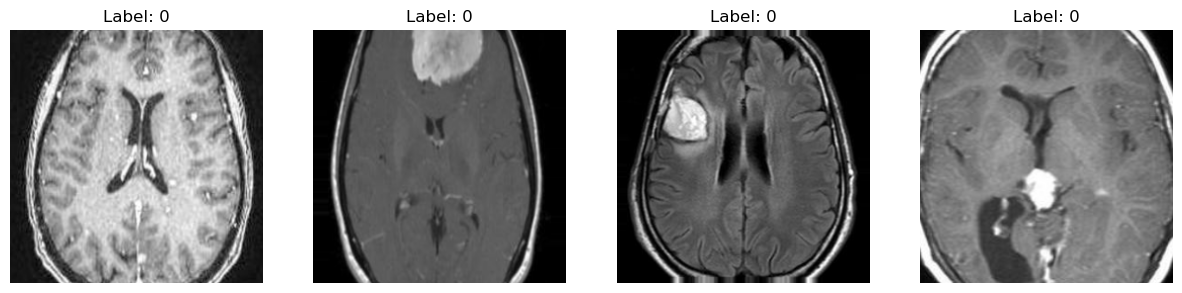

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def residual_block(inputs, num_filter):
    # Convolution layers
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(inputs)
    x = Conv2D(num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Conv2D(2*num_filter, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Skip connection
    if inputs.shape[-1] != num_filter:
        shortcut = Conv2D(2*num_filter, kernel_size=(1,1), padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut=inputs
        
    shortcut = MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(shortcut)
    # add skip connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [7]:
def cbam_block(cbam_feature, ratio=8):
    # Channel Attention Module
    channel_avg = GlobalAveragePooling2D()(cbam_feature)
    channel_max = GlobalAveragePooling2D()(cbam_feature)
    channel_avg = Reshape((1, 1, K.int_shape(cbam_feature)[-1]))(channel_avg)
    channel_max = Reshape((1, 1, K.int_shape(cbam_feature)[-1]))(channel_max)
    channel_avg = Dense(K.int_shape(cbam_feature)[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(channel_avg)
    channel_max = Dense(K.int_shape(cbam_feature)[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(channel_max)
    channel_avg = Dense(K.int_shape(cbam_feature)[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(channel_avg)
    channel_max = Dense(K.int_shape(cbam_feature)[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(channel_max)
    channel_attention = multiply([cbam_feature, channel_avg + channel_max])

    # Spatial Attention Module
    spatial_avg = K.mean(channel_attention, axis=-1, keepdims=True)
    spatial_max = K.max(channel_attention, axis=-1, keepdims=True)
    spatial_attention = add([spatial_avg, spatial_max])
    spatial_attention = Activation('sigmoid')(spatial_attention)

    return multiply([channel_attention, spatial_attention])


In [8]:
 def VGG_residual(inputs_shape):    
    inputs = Input(shape=input_shape)
    
    x = residual_block(inputs, 64) # 2 conv layers
    
    x = cbam_block(x)
    
    x = residual_block(x, 256) # 2 conv layers
    
    x = cbam_block(x)
    
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=he_normal())(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    

    x = Conv2D(4096, (1,1), activation='relu')(x)

    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model


In [9]:
model = VGG_residual(input_shape)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:

model.compile(loss='binary_crossentropy', optimizer='adaGrad', metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, epochs=60, validation_data =(validation_generator), verbose=1)

Epoch 1/60
776/776 [==============================] - 65s 79ms/step - loss: 0.6830 - accuracy: 0.5878 - val_loss: 0.6373 - val_accuracy: 0.6436
Epoch 2/60
776/776 [==============================] - 47s 60ms/step - loss: 0.6214 - accuracy: 0.6607 - val_loss: 0.6103 - val_accuracy: 0.6451
Epoch 3/60
776/776 [==============================] - 46s 59ms/step - loss: 0.5908 - accuracy: 0.6887 - val_loss: 0.5890 - val_accuracy: 0.6647
Epoch 4/60
776/776 [==============================] - 47s 61ms/step - loss: 0.5513 - accuracy: 0.7116 - val_loss: 0.6058 - val_accuracy: 0.6917
Epoch 5/60
776/776 [==============================] - 46s 60ms/step - loss: 0.5184 - accuracy: 0.7419 - val_loss: 0.5338 - val_accuracy: 0.7008
Epoch 6/60
776/776 [==============================] - 46s 59ms/step - loss: 0.4933 - accuracy: 0.7599 - val_loss: 0.5459 - val_accuracy: 0.6947
Epoch 7/60
776/776 [==============================] - 47s 61ms/step - loss: 0.4650 - accuracy: 0.7770 - val_loss: 0.4801 - val_accuracy:

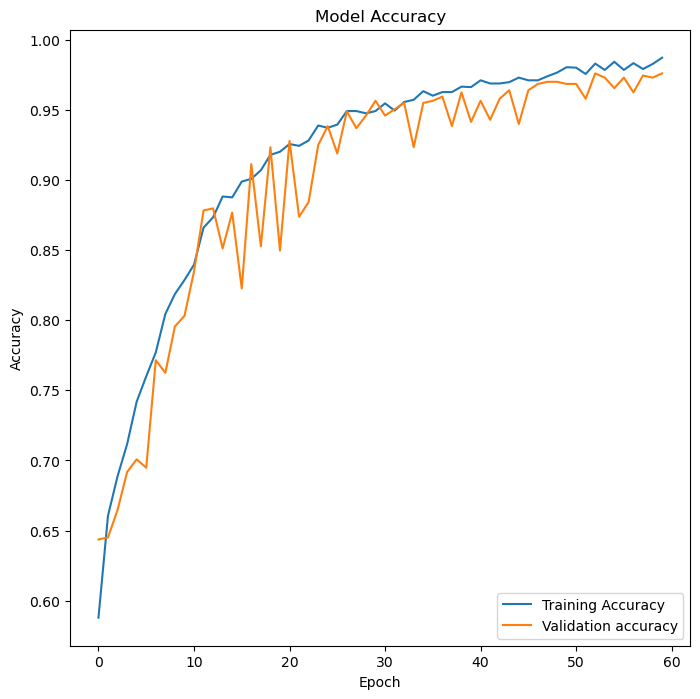

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation accuracy'], loc='lower right')

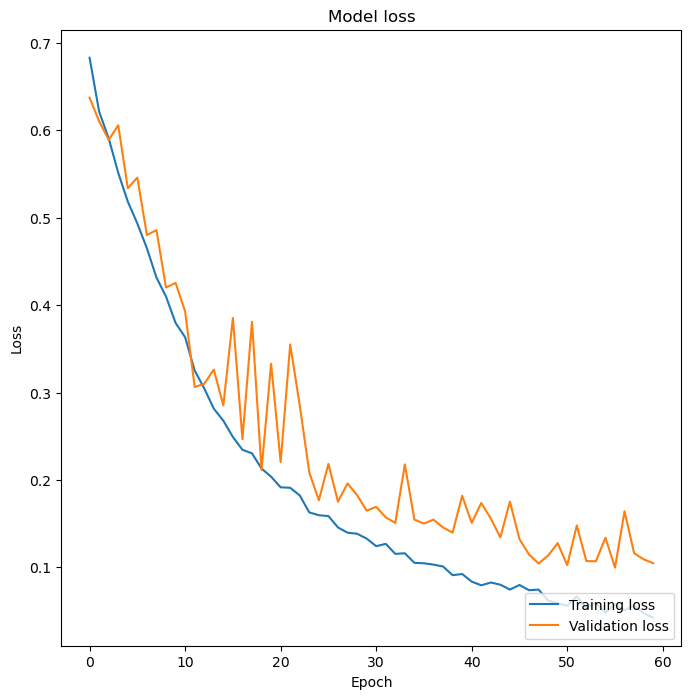

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], loc='lower right')
plt.show()

In [15]:
loss, accurancy = model.evaluate(test_generator)
print('Test loss:', loss)
print("Test accurancy", accurancy)

167/167 [==============================] - 4s 26ms/step - loss: 0.0804 - accuracy: 0.9730
Test loss: 0.08041159808635712
Test accurancy 0.9729729890823364


In [16]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

#compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[185 169]
 [171 141]]


In [17]:
#compute f1-score
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred_labels)
print('F1-score:', f1)

F1-score: 0.4533762057877814


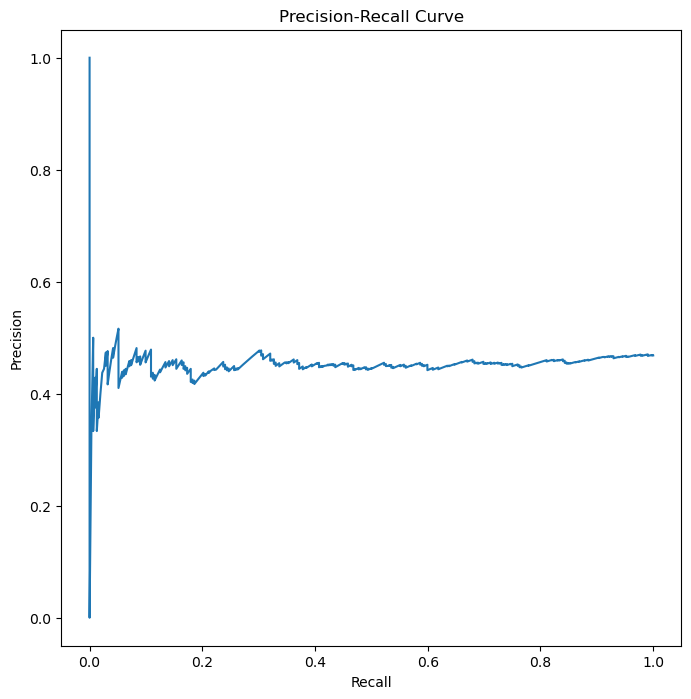

In [18]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

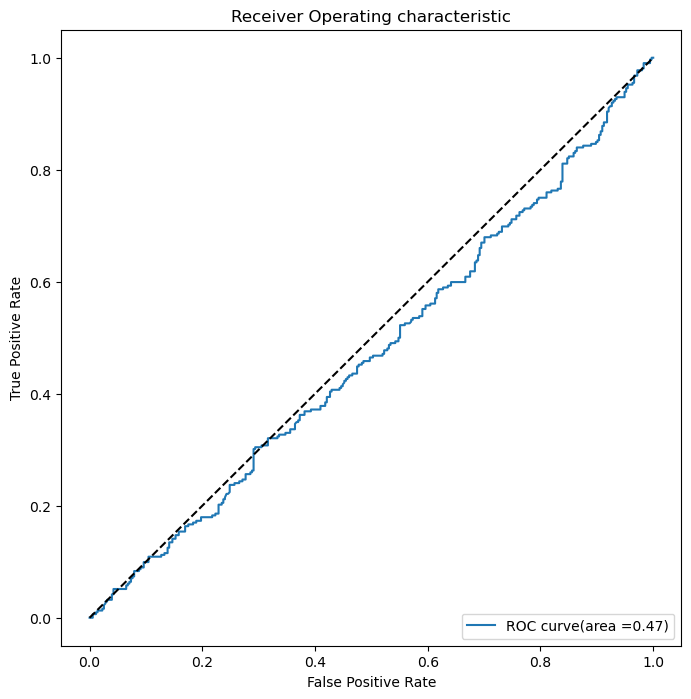

In [19]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [20]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 0.9971751412429378


In [1]:
model.save("vra.h6")

NameError: name 'model' is not defined